# Modal Tutorial 05 Part A: Computing Frequency Response from Time Data

In the previous tutorials, we learned how we could compute frequency response functions from system matrices (mass, stiffness, and damping) as well as from modal parameters (natural frequency, mode shape, and damping ratio).  However, for real systems, there is no mass, stiffness, or damping matrices from which the frequency response functions or mode shapes could be computed.  Instead we need to develop these parameters from the response of a system due to some excitation applied to it.

The first step in this process is to compute frequency response functions from the time data, to which modal parameters can be fit.

## Sinusoidal Excitation

In the second modal tutorial on single degree of freedom systems, we discovered a way to map the frequency response function of a system.  We could, for example, play in a sinusoidal excitation at a given frequency line, and then compute the magnitude and phase of the responses to map the response to the excitation.  This is certainly a viable approach to mapping the frequency response of the system, but it has some drawbacks.  For example, we will need to perform a test at every frequency line for every excitation location that we wish to compute the excitation location at.

Let's show a brief example using the plate structure from the last tutorial.  First let's set up the parameters of our test.

In [1]:
# Import sdynpy for structural dynamics
import sdynpy as sdpy
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import numpy for numerics
import numpy as np
# Import the system and geometry so we can simulate time responses
from sdynpy.demo.beam_plate import system,geometry

# Compute modes so we can integrate the modal equations of motion, which
# is quicker than integrating the full equations of motion
shapes = system.eigensolution(maximum_frequency=1000)
# Apply some damping to the system for realism
shapes.damping = 0.01 # 1% damping
# Add a small stiffness and damping to the rigid body modes so
# the part doesn't go flying off into space with any excitation
shapes.frequency[:6] = 0.01

# Compute the modal system from the shapes
modal_system = shapes.system()

# Set up a set of input excitation locations
excitation_locations = sdpy.coordinate_array(string_array=[
    '1Z+','41Z+'
    ])

# Set up a set of response locations
response_locations = sdpy.coordinate_array(geometry.node.id,3)

# Plot the excitation locations so we can see where we are exciting
# the structure
geometry.plot_coordinate(excitation_locations,label_dofs=True);

![plate_excitation_locations.gif](figures/plate_excitation_locations.gif)

We can see that we are exciting the corners of the plate in the direction perpendicular to the plate.

Let's now let's excite one of the excitation locations with a single frequency sine wave.

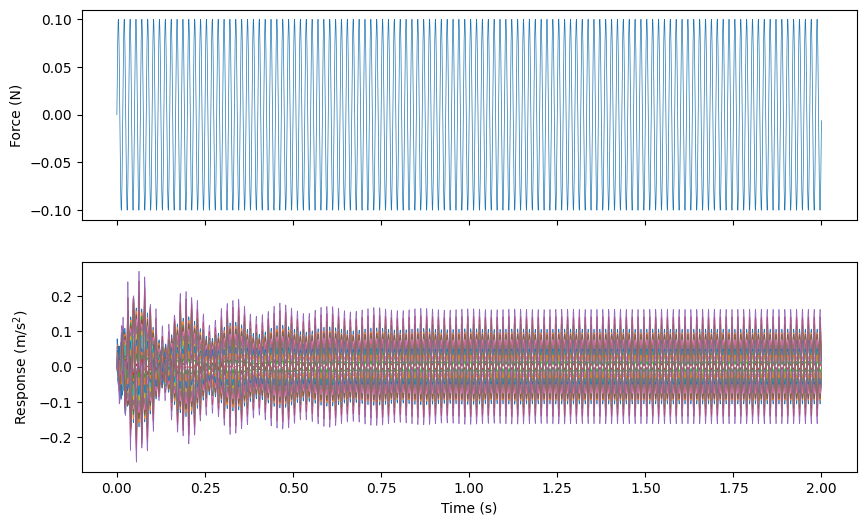

In [2]:
# Select the frequency and the location of excitation
excitation_location = excitation_locations[0]
excitation_frequency = 60.0 # Hz
excitation_amplitude = 0.1 # N

# Now set up the excitation signal
sample_rate = excitation_frequency*100 # Oversample 100 times for accuracy
dt = 1/sample_rate
sample_length = 2.0 # Seconds
num_samples = int(sample_rate*sample_length)
excitation_signal = sdpy.generator.sine(
    excitation_frequency,dt,num_samples,excitation_amplitude)
references = sdpy.time_history_array(
    np.arange(excitation_signal.shape[-1])*dt,
    excitation_signal,
    excitation_location)[np.newaxis]
# Now integrate the equations of motion and compute responses at
# all the nodes in the vertical direction
responses = modal_system.time_integrate(
    references,
    {2:response_locations}) # Get accelerations

# Plot the responses and the references
fig,ax = plt.subplots(2,1,num='Excitation and Response to Sinusoidal Input',
                     figsize=(10,6),sharex=True)
references.plot(ax[0],plot_kwargs={'linewidth':0.5})
responses.plot(ax[1],plot_kwargs={'linewidth':0.5})
ax[0].set_ylabel('Force (N)')
ax[1].set_ylabel('Response (m/s$^2$)')
ax[1].set_xlabel('Time (s)');

We can see that there are some start-up transients, but after about a second and a half, the system has reached steady state, so we can compute the amplitude and phase of the signals at this point.

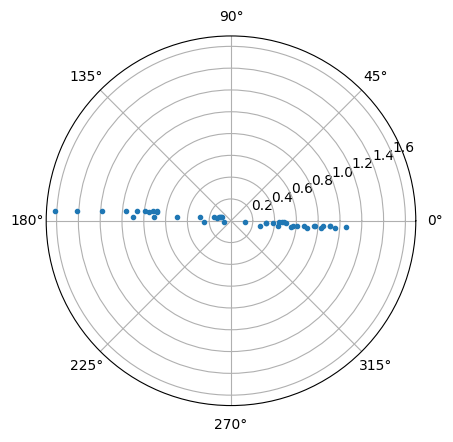

In [3]:
steady_state_responses = responses.extract_elements_by_abscissa(1.5,np.inf)
steady_state_references = references.extract_elements_by_abscissa(1.5,np.inf)

response_magnitudes = []
response_phases = []
for response in steady_state_responses:
    magnitude,phase = sdpy.harmonic.harmonic_mag_phase(response.abscissa,
                                                      response.ordinate,
                                                      excitation_frequency)
    response_magnitudes.append(magnitude[0])
    response_phases.append(phase[0])

response_complex = np.array(response_magnitudes)*np.exp(
    1j*np.array(response_phases))
    
reference_magnitudes = []
reference_phases = []
for reference in steady_state_references:
    magnitude,phase = sdpy.harmonic.harmonic_mag_phase(reference.abscissa,
                                                      reference.ordinate,
                                                      excitation_frequency)
    reference_magnitudes.append(magnitude[0])
    reference_phases.append(phase[0])

reference_complex = np.array(reference_magnitudes)*np.exp(
    1j*np.array(reference_phases))

frf_line = response_complex/reference_complex

# Let's plot the values on the complex plane
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.plot(np.angle(frf_line),np.abs(frf_line),'.')

# Also we can plot it on the geometry
deflection_shape = sdpy.shape_array(responses.coordinate[:,0],
                                   frf_line[np.newaxis,:],
                                   frequency=excitation_frequency)
geometry.plot_shape(deflection_shape)

![deflection_shape_60_hz.gif](figures/deflection_shape_60_hz.gif)

Here we show a single line of the frequency response function matrix for all $z$-direction responses from the excitation at node 1.  We plot it on the complex plane to show the range of amplitudes and phases associated with this deflection shape.  More intuitively, we also plot this as deflections on the geometry.  We could do this for a large number of frequency lines for all input locations to map out a frequency response function matrix.

In [4]:
excitation_frequencies = np.linspace(50,120,71)

frf_matrix = np.empty((response_locations.size,
                       excitation_locations.size,
                       excitation_frequencies.size),dtype=complex)

for k,excitation_frequency in enumerate(excitation_frequencies):
    for j,excitation_location in enumerate(excitation_locations):
        # Set up the excitation signal
        sample_rate = excitation_frequency*100 # Oversample 100 times
        dt = 1/sample_rate
        sample_length = 2.0 # Seconds
        num_samples = int(sample_rate*sample_length)
        excitation_signal = sdpy.generator.sine(
            excitation_frequency,dt,num_samples,excitation_amplitude)
        references = sdpy.time_history_array(
            np.arange(excitation_signal.shape[-1])*dt,
            excitation_signal,
            excitation_location)[np.newaxis]
        # Now integrate the equations of motion and compute responses at
        # all the nodes in the vertical direction
        responses = modal_system.time_integrate(
            references,
            {2:response_locations}) # Get accelerations
        
        steady_state_responses = responses.extract_elements_by_abscissa(
            1.5,np.inf)
        steady_state_references = references.extract_elements_by_abscissa(
            1.5,np.inf)

        response_magnitudes = []
        response_phases = []
        for response in steady_state_responses:
            magnitude,phase = sdpy.harmonic.harmonic_mag_phase(
                response.abscissa,response.ordinate,excitation_frequency)
            response_magnitudes.append(magnitude[0])
            response_phases.append(phase[0])

        response_complex = np.array(response_magnitudes)*np.exp(
            1j*np.array(response_phases))

        reference_magnitudes = []
        reference_phases = []
        for reference in steady_state_references:
            magnitude,phase = sdpy.harmonic.harmonic_mag_phase(
                reference.abscissa,reference.ordinate,excitation_frequency)
            reference_magnitudes.append(magnitude[0])
            reference_phases.append(phase[0])

        reference_complex = np.array(reference_magnitudes)*np.exp(
            1j*np.array(reference_phases))

        frf_line = response_complex/reference_complex
        frf_matrix[:,j,k] = frf_line
        
# Create a TransferFunctionArray
frf_coordinates = sdpy.coordinate.outer_product(response_locations,
                                               excitation_locations)
frf_sine = sdpy.data_array(
    sdpy.data.FunctionTypes.FREQUENCY_RESPONSE_FUNCTION,
    excitation_frequencies,frf_matrix,frf_coordinates)

# Plot the transfer functions in 2D and in 3D
guiplot = sdpy.GUIPlot(frf_sine)
dsplot = geometry.plot_deflection_shape(frf_sine[:,0])

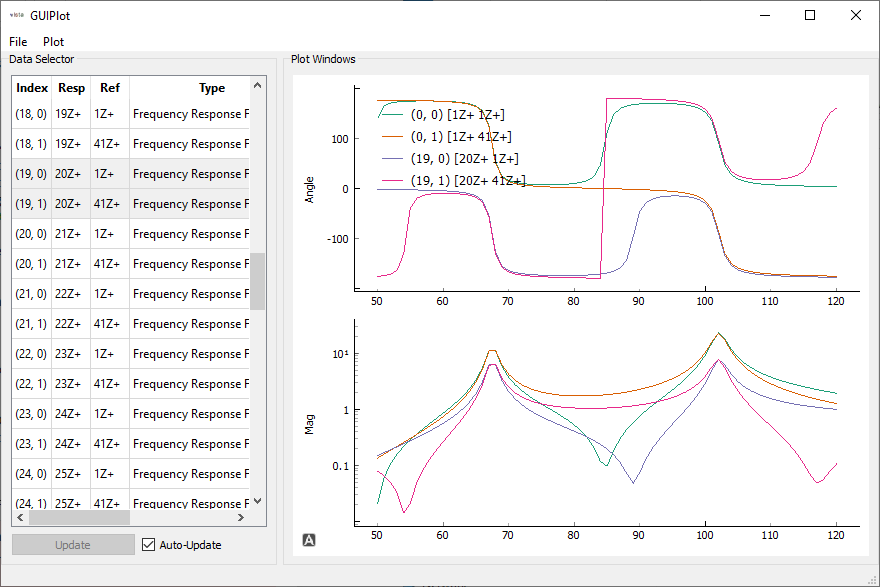

The GUIPlot provides a way to interactively view the 2D frequency response functions we have just created.

![sine_deflection_multiline_animation.gif](figures/sine_deflection_multiline_animation.gif)

The frequency response functions can also be plotted with the deflection shape plotter, which allows the user to interactively investigate the deflection shape at specific frequency lines.

## Broadband Excitation

While the sinusoidal excitation technique is a perfectly valid way to compute frequency response functions, it is incredibly slow. We analyze the system one line at a time, and one excitation location at a time.  In a real test, changing the excitation frequency will likely involve interacting with the graphical user interface, which when performed a large number of times will result in a very long-running and tedious test.  Additionally, changing between excitation locations will involve moving and re-aligning shakers, which can be very tedious as well if there are a large number of excitation locations required.  Therefore, it is generally advantageous to apply some kind of broadband excitation to the system that excites multiple frequency lines simultaneously.  Subsequent tutorials will discuss the advantages and disadvantages of different types of excitation.  For now, we will simply discuss how to compute frequency response functions from broadband time history data.

For this example, we will use the same system, but rather than exciting the system with a signal containing one sine wave, we will instead excite the structure using a signal that is a summation of many sine waves with randomized phases.

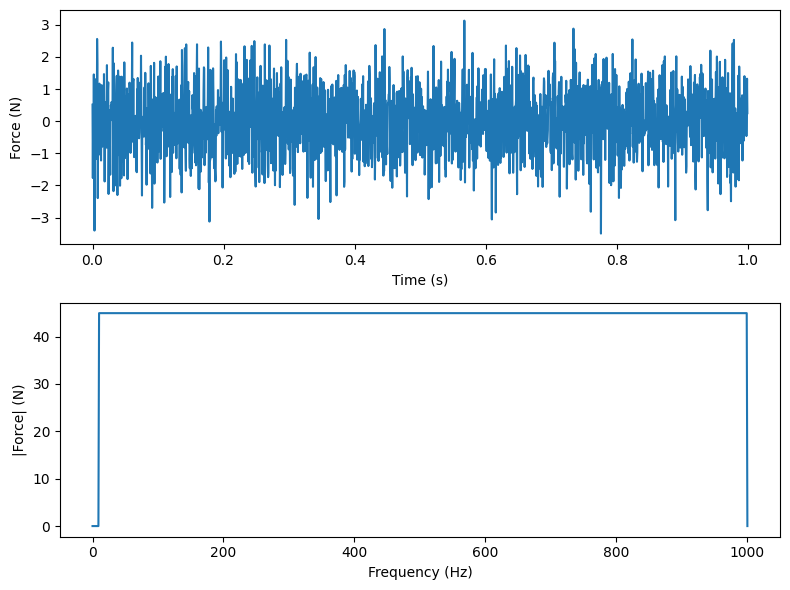

In [5]:
frequencies = np.arange(10,1000)
phases = np.random.rand(frequencies.size)*2*np.pi
sample_rate = 2000
dt = 1/sample_rate
num_samples = 2000
excitation_signal = np.sum(
    sdpy.generator.sine(frequencies,dt,num_samples,phases=phases),axis=0)
# Scale to 1 N RMS
rms = np.sqrt(np.mean(excitation_signal**2))
excitation_signal/=rms

excitation_signal_fft = np.fft.rfft(excitation_signal)
excitation_signal_freqs = np.fft.rfftfreq(num_samples,dt)

fig,ax = plt.subplots(2,1,num='Pseudorandom Excitation',figsize=(8,6))
ax[0].plot(dt*np.arange(num_samples),excitation_signal)
ax[1].plot(excitation_signal_freqs,np.abs(excitation_signal_fft))
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('|Force| (N)')
fig.tight_layout()

We can see by computing the FFT of the excitation signal that there is indeed frequency content between 10 and 1000, which are the sine waves that were used to create the signal.  Let's play this signal into our system at each excitation locations in order to get the responses.  Note that we will be interested in the steady state response, so we will play the signal multiple times to allow the system to reach steady state, and only keep the responses for the last repeat of the signal.

In [6]:
# Copy the signal 3 times to allow the system to come to steady state
excitation_signal = np.tile(excitation_signal,3)
excitation_location = excitation_locations[0]
references = sdpy.time_history_array(
    np.arange(excitation_signal.shape[-1])*dt,
    excitation_signal,
    excitation_location)
responses = modal_system.time_integrate(
    references,
    {2:response_locations}, # Get accelerations
    integration_oversample=10) 
steady_state_responses = responses.extract_elements(
    slice(-num_samples,None))
steady_state_references = references.extract_elements(
    slice(-num_samples,None))

### Computing FRFs using FFTs

Now that we have the steady state response, we would like to try to compute the frequency response functions.  One potential approach is to use the FFT to compute the frequency spectrum at each line, and then divide each response frequency line by each reference frequency line to produce the frequency response function matrix.

In [7]:
response_fft = steady_state_responses.fft()
reference_fft = steady_state_references.fft()

frf_matrix = response_fft.ordinate/reference_fft.ordinate

frf_broadband = sdpy.data_array(
    sdpy.data.FunctionTypes.FREQUENCY_RESPONSE_FUNCTION,
    reference_fft.abscissa,frf_matrix,frf_coordinates[:,0])

We can then repeat the process with the other excitation location.

In [8]:
excitation_location = excitation_locations[1]
references = sdpy.time_history_array(
    np.arange(excitation_signal.shape[-1])*dt,
    excitation_signal,
    excitation_location)
responses = modal_system.time_integrate(
    references,
    {2:response_locations}, # Get accelerations
    integration_oversample=10) 
steady_state_responses = responses.extract_elements(
    slice(-num_samples,None))
steady_state_references = references.extract_elements(
    slice(-num_samples,None))
response_fft = steady_state_responses.fft()
reference_fft = steady_state_references.fft()

frf_matrix = response_fft.ordinate/reference_fft.ordinate

frf_broadband = np.concatenate((frf_broadband[:,np.newaxis],sdpy.data_array(
    sdpy.data.FunctionTypes.FREQUENCY_RESPONSE_FUNCTION,
    reference_fft.abscissa,frf_matrix,frf_coordinates[:,1])[:,np.newaxis]),
                              axis=-1)

Now let's compare the frequency response functions created from the narrow and broadband excitation.

In [9]:
guiplot = sdpy.GUIPlot(frf_broadband,frf_sine)

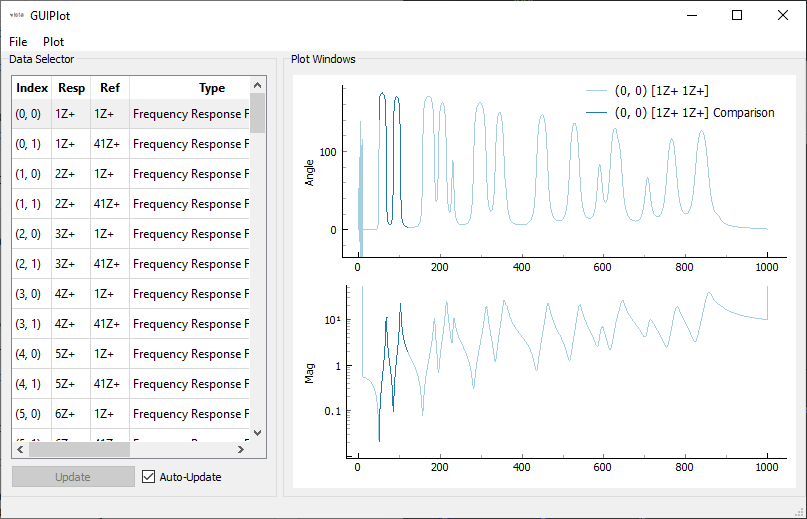

We can see that there is very good agreement between the frequency response function matrix created from the narrow-band excitation and the frequency response function matrix created from the broad-band excitation.

### Computing FRFs with Power Spectra

While frequency response function matrix can be computed with FFTs, there are limitations with this approach.  For example, this approach can not handle multiple simultaneous inputs, because there is no way to separate the response contributions from each input.  Additionally, because experimental data inevitably has noise and error sources, it is generally adventageous to perform averaging over multiple measurement frames rather than just using a single frame as was done previously.  Computing frequency response function matrices with power spectra can accommodate simultaneous excitation signals at multiple locations, and can also accommodate averaging by using techniques such as Bartlett's or Welch's methods of computing the Power Spectra.  Therefore, these classes of techniques are the most common approaches to computing the frequency response function matrix for a test.

#### Computing Power Spectra

Computing the frequency response function matrix starts with computing power spectra between various signals.  In general, a power spectrum is computed by multiplying one FFT spectrum with the complex conjugate of a second FFT spectrum.  Typically, there is more complex scaling that would need to be performed to ensure the units are correct on the power spectra; however, since the FRF computation will generally consist of ratios of power spectra, this scaling will cancel out, so we can ignore the scaling of the FFT in this case.

The general formula will be

$$\mathbf{P}_{XY} = \mathbf{X} \mathbf{Y}^*$$

Where $\mathbf{P}_{XY}$ is the power spectra between signals $\mathbf{X}$ and $\mathbf{Y}$, and the operator $^*$ denotes the complex conjugate transpose.  This computation is performed per frequency line.

When computing frequency response function matrices, we will generally separate the response spectra $X$ from the force spectra $F$ when computing power spectra.  For example, the cross-power spectral matrix between force and response would be

$$\mathbf{P}_{XF} = \mathbf{X} \mathbf{F}^*$$

and the auto-power spectral matrix for the response would be

$$\mathbf{P}_{XX}  = \mathbf{X}\mathbf{X}^*$$

Recall that we mentioned the concept of averaging to reduce noise.  We can compute multiple realizations of the power spectra matrix using different portions of the time history to compute FFT spectra.  These portions of the time history may overlap, be sequential, or have gaps between them, depending on the type of signal that is being used for a given test.  This will be covered more thoroughly in the next tutorial.

$$\mathbf{P}_{XY} = {\sum_{i=1}^n \mathbf{X}_i \mathbf{Y}_i^* \over n}$$

Note again that when computing frequency response function matrices, we will be computing ratios of power spectra, so the number of averages $n$ will cancel out.  Therefore, a small (probably insignificant) amount of computation can be saved by simply summing the averages rather than taking the mean in this case.

Let's briefly attempt to add some intuition to the formula for the power spectra matrix.  Note that the FFT spectra $\mathbf{X}$ and $\mathbf{Y}$ will be complex numbers.  From complex number theory, we know that multiplying two complex numbers results in multiplying the magnitude of the complex numbers and adding the phases.  We also know that taking the conjugate of a complex number flips the sign on the imaginary part of the complex number, which also flips the sign on the phase of the number.  For example, the complex number $1+i$ has a phase of 45 degrees or $\pi/4$ radians.  If we take the complex conjugate of the complex number, it becomes $1-i$, which has a phase of -45 degrees of $-\pi/4$ radians.

So now let us think about what is happening in the formula $\mathbf{X} \mathbf{Y}^*$: we are multiplying the magnitude of the complex numbers $\mathbf{X}$ and $\mathbf{Y}$ and adding the phase of $\mathbf{X}$ to the negative phase of $\mathbf{Y}$.  In other words, we are subtracting the phase of $\mathbf{Y}$ from the phase of $\mathbf{X}$.  If we are computing the auto-power spectra matrix, where $\mathbf{Y}=\mathbf{X}$, i.e. $\mathbf{X} \mathbf{X}^*$, we will effectively be computing the magnitude squared of $\mathbf{X}$, which will be real, because we will be subtracting the phase of $\mathbf{X}$ from itself, which will result in a phase equal to zero.

Note that this *subtraction of phases* is relevant when we compute frequency response functions, because the phase of the frequency response function matrix represents the difference in phase between the response and the excitation.  However, if we compute the quantity $\mathbf{X}\mathbf{F}^*$, and call it the frequency response function, we will have the correct phase, but not the correct magnitude.  The magnitude of the frequency response function should be the ratio between the magnitude of the response and the magnitude of the excitation, not the product between the two.  However, if we were to, for example, divide the product $\mathbf{X}\mathbf{F}^*$ by the product $\mathbf{F}\mathbf{F}^*$, we would see that we have a matrix with a magnitude that is equal to the magnitude of the response times the magnitude of the excitation divided by the magnitude of the excitation squared, which will result in a magnitude of the response magnitude over the force magnitude.  The phase of $\mathbf{X}\mathbf{F}^*$ will be the phase between the response and the excitation, and the phase of $\mathbf{F}\mathbf{F}^*$ is equal to zero, so the phase of the matrix will also be the desired phase difference between response and excitation.  Therefore, for the basic frequency response function computation schemes, we will generally be computing the ratio of some auto-power term $\mathbf{P}_{XX}$ or $\mathbf{P}_{FF}$ and some cross-power term $\mathbf{P}_{XF}$ or $\mathbf{P}_{FX}$.

Note that the true situation is a bit more complex that what was described here due to the fact that $\mathbf{X}$ and $\mathbf{Y}$ can be vectors when there are multiple excitations or multiple responses; however, this can be used as a mental model of the process to help remember the formula.

#### The H<sub>1</sub> Technique

Perhaps the most common frequency response function computation technique is the **H<sub>1</sub> Technique**.  This technique assumes there is no noise on the input to the system (e.g. the excitation force signal) and minimizes the error on the output (e.g. responses such as acceleration).  This technique is particularly useful because the test practitioner typically has some amount of control over the force going into the system.  For example the user can specify the voltage going into a shaker to excite a structure, or hit the part harder with an impact hammer.  This means the excitation signal should rarely be "in the noise floor" of the measurement.  This can be juxtaposed against the response signal, which is determined heavily by the dynamic characteristics of the part.  For example, there may be antiresonances at certain locations and certain frequencies, where regardless of how much force is applied, the response will still be very small, and perhaps in the noise floor of the measurement.  Also, if optical techniques such as digital image correlation or laser vibrometery are used to measure the response, these will generally have a much higher noise floor than the force transducers used to measure the force into the part.  Disadvantages of the H<sub>1</sub> technique include underestimating the frequency response function at resonances and therefore overestimating the the damping.

The estimate of the frequency response function matrix using the H1 technique is computed by

$$\mathbf{H}_1 = \mathbf{P}_{XF} {\mathbf{P}_{FF}}^{-1}$$

which is the ratio of the cross-power spectra matrix $\mathbf{P_{XF}}$ and the auto-power spectra matrix $\mathbf{P_{FF}}$.

#### The H<sub>2</sub> Technique

Unlike the H<sub>1</sub> technique, the **H<sub>2</sub> Technique** is not commonly used.  Instead of minimizing the noise on the responses, it instead minimizes noise on the excitation signals.  It will also overestimate the frequency response function matrix at resonance and therefore understimate damping.  The equation for the H<sub>2</sub> technique is

$$\mathbf{H}_2 = \mathbf{P}_{XX} {\mathbf{P}_{FX}}^{-1}$$

which is the ratio of the auto-power spectra matrix $\mathbf{P}_{XX}$ and the cross-power spectra matrix $\mathbf{P}_{FX}$.  Note the implications of this formula.  Because the matrix $\mathbf{P}_{FX}$ needs to be inverted, the matrix must be square if multiple input forces are applied.  This restricts the H<sub>2</sub> frequency response function estimate to cases where the number of responses is equal to the number of excitation signals (which is very rarely the case) or when the number of excitation signals is 1 (in which case, each response can be treated independently as if it were a single-input, single-output test).  This restriction greatly reduces the utility of the H<sub>2</sub> technique, so it is seldom used.

#### The H<sub>3</sub> Technique

While the H<sub>1</sub> technique generally underestimates frequency response functions
and the H<sub>2</sub> technique generally overestimates frequency response functions, it may seem reasonable to average together the two estimates, because the true frequency response function must be somewhere in the middle, right?  This is exactly the reasoning behind the **H<sub>3</sub> Technique** which is simply the average of the H<sub>1</sub> and H<sub>2</sub> estimations.

$$\mathbf{H}_3 = {\mathbf{H}_1 + \mathbf{H}_2 \over 2}$$

Note that because the H<sub>2</sub> estimator is computed in order to compute the H<sub>3</sub> estimator, all restrictions of that technique also apply to this one.

#### The H<sub>CD</sub> Technique

When performing multiple input excitation on a system, it is generally required that the inputs be uncorrelated from one another.  However, in a real test, even when uncorrelated voltages are applied to the shakers, correlated forces may result due to the motion of the test article, which will tend to be correlated, pushing against the shaker resulting in forces being generated.  To remove this partial correlation of the input forces, the forces are conditioned using the Cholesky Decomposition (hence the CD of H<sub>CD</sub>) of the input power spectral matrix $\mathbf{P}_{FF}$.

$$\mathbf{P}_{FF} = \mathbf{L}_{FZ}\mathbf{L}_{ZF}$$
$$\mathbf{P}_{XZ} = \mathbf{P}_{XF}\mathbf{L}_{ZF}^{-1}$$
$$\mathbf{H}_{CD} = \mathbf{P}_{XZ}\mathbf{L}_{FZ}^{-1}$$

One can alternatively use the square-root-free Cholesky Decomposition.

$$\mathbf{P}_{FF} = \mathbf{L}_{FZ}\mathbf{P}_{ZZ}\mathbf{L}_{ZF}$$
$$\mathbf{P}_{XZ} = \mathbf{P}_{XF}\mathbf{L}_{ZF}^{-1}$$
$$\mathbf{H}_{XZ} = \mathbf{P}_{XF}\mathbf{P}_{ZZ}^{-1}$$
$$\mathbf{H}_{CD} = \mathbf{H}_{XZ}\mathbf{L}_{FZ}^{-1}$$

Because many matrix inversion techniques will automatically use Cholesky Decomposition for Hermetian, positive-definite matrices, the H<sub>CD</sub> is functionally equivalent to the H<sub>1</sub> formulation.

#### The H<sub>v</sub> Technique

While the previous techniques assume the noise is either on the input or the output, the H<sub>v</sub> technique assumes there is noise on both input and output.  Starting with the equations

$$\mathbf{H}\mathbf{P}_{FF} = \mathbf{P}_{XF}$$
$$\mathbf{H}\mathbf{P}_{FX} = \mathbf{P}_{XX}$$

we can assemble a matrix equation

$$\begin{bmatrix}\mathbf{H}&-1\end{bmatrix} \begin{bmatrix}\mathbf{P}_{FF} & \mathbf{P}_{FX} \\ \mathbf{P}_{XF} & \mathbf{P}_{XX} \end{bmatrix} = \mathbf{0}$$

This can also be expressed as 

$$\begin{bmatrix}\mathbf{P}_{FF} & \mathbf{P}_{FX} \\ \mathbf{P}_{XF} & \mathbf{P}_{XX} \end{bmatrix}^T\begin{bmatrix}\mathbf{H}\\-1\end{bmatrix} = \mathbf{0}$$

We can solve problems of the form $\mathbf{A}\mathbf{x}=\mathbf{0}$ by this problem by computing the eigenvector of
$\mathbf{A}$ that corresponds to the smallest eigenvalue.  This eigenvector gives the best approximation for $\mathbf{x}$.  By scaling the last row of the eigenvector such that is equal to -1, we can recover the frequency response function $\mathbf{H}$.

One interesting feature of this technique is that it should be computed *per output* degree of freedom, so matrices $\mathbf{P}_{XX}$, $\mathbf{P}_{XF}$, and $\mathbf{P}_{FX}$ should be constructed using one $X$ at a time.  Otherwise, the responses will affect one another if the entire matrix is assembled at once and the eigenvectors are computed.

### Coherence

When constructing frequency response functions, we are computing the relationship between the outputs of our system (i.e. the responses) due to the inputs applied to the system (i.e. the forces).  The **coherence** is an important metric that shows us how much of the response can be attributed to the forces being applied.  The coherence can take a value between 0 and 1, where a value of 1 means that all of the responses are due to the inputs, and a value of 0 means that the responses are not related to the inputs at all.

There are many reasons poor coherence may occur in a test, and a few common reasons.  If the excitation level is very low, noise in the measurement may contribute significantly to the response, and this noise will not be related to the input applied.  For this reason, we often see coherence drops at anti-resonances in the frequency response function: the response is very small, so noise in the measurement can be signficant.

If the forces into the system are not measured entirely, the coherence can also suffer; for example if the force is measured using a uniaxial force sensor, but there is also some side loading or bending moment applied to the structure, these unmeasured forces and moments will still contribute to measurable responses of the system, and these responses may not correlate to the measured input.  Finally if a force is applied to a system and the entire response is not measured, for example if we impact a system and stop the measurement while the system is still responding from the impact, the coherence will be lower due to a portion of the response being missing.

Coherence between an input $F$ and response $X$ can be computed as

$$\gamma^2 = {{\mathbf{P}_{XF}{\mathbf{P}_{XF}}^*}\over{\mathbf{P}_{XX}\mathbf{P}_{FF}}} = {{\|\mathbf{P}_{XF}\|^2}\over{\mathbf{P}_{XX}\mathbf{P}_{FF}}}$$

There will be one value of $\gamma^2$ for each output/input pair in the test at each frequency line.

This formulation is often used for single-input testing, because all response is expected to be due to that single input.  However, if this formulation is used for multiple-input testing, any given value of $\gamma^2$ for an output-input pair is expected to be less than 1.  This is because any given response is expected to have some contribution from input 1, some contribution from input 2, ... some contribution from input $n$.  No response can be expected to be 100% correlated to a single input when multiple inputs are present.  In the multiple-input testing case, we instead compute the **Multiple Coherence** function, which shows how much a given response is correlated to *all* inputs.  There will therefore be one value of the multiple coherence function for each response in the test at each frequency line.

$$Mcoh = {\mathbf{P}_{XF}{\mathbf{P}_{FF}}^{-1}{\mathbf{P}_{XF}}^* \over {\mathbf{P}_{XX}}}$$

## Computing Frequency Response Functions using SDynPy

Frequency response functions can be computed in SDynPy using either code or interactive windows.  The primary functions that will be useful for computing frequency response functions are `TransferFunctionArray.from_time_data` and `SignalProcessingGUI`.

To demonstrate this functionality, a demonstration test will be performed using the `beam_airplane` demonstration in the `sdynpy.demo` package.  We will import the `system` and `geometry` from the `sdynpy.demo.beam_airplane` module along with the other necessary imports.

In [10]:
import numpy as np # For Numerics
import matplotlib.pyplot as plt # For Plotting

import sdynpy as sdpy # For Structural Dynamics

# Get the demonstration system and geometry
from sdynpy.demo.beam_airplane import system,geometry

To make the computations faster, we will reduce down to a modal system containing the modes below 50 Hz.  We do this by computing the modes of the system using the `eigensolution` method of the `system` object.  We apply a reasonable damping fraction (2%) and then create modal system from the shapes.

In [11]:
shapes = system.eigensolution(maximum_frequency=50)
shapes.damping = 0.02
system = shapes.system()

We then select response and reference degrees of freedom.  To keep things simple, we will look at an FRF from a force at one wingtip to the response at the other wingtip.

In [12]:
# Set up references are responses
references = sdpy.coordinate_array([201],3)
responses = sdpy.coordinate_array([241],3)

geometry.plot_coordinate(np.unique(np.concatenate((references,responses))),label_dofs=True);

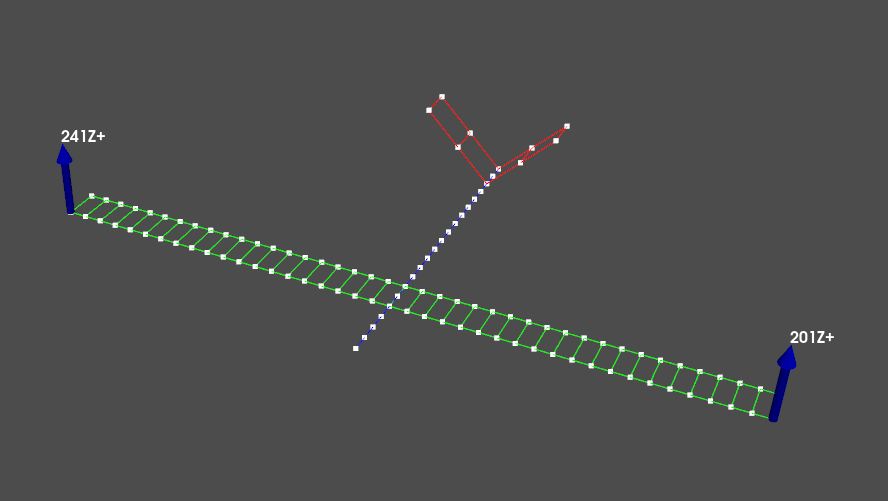

We will then compute the truth frequency response functions for this system, so we can compare our frequency response functions computed from time data to those computed directly from the system matrices.

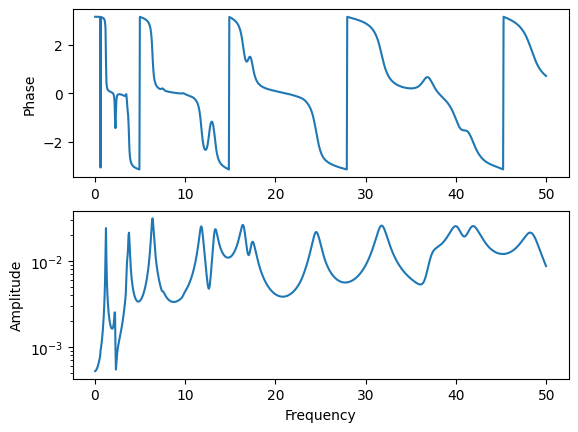

In [13]:
# Set up the frequencies we will compute the FRF at
frequencies = (1+np.arange(999))*0.05

# Compute the truth FRF from system matrices
frf_truth = system.frequency_response(frequencies,responses,references,2)

# Plot the FRF to make sure it looks right.
frf_truth.plot();

At this point, we can simulate a modal test.  We will do this using the `simulate_test` method of the `system` object, specifying a bandwidth of 50 Hz, a frame length of 2000 samples, 50 averages, pseudorandom excitation, our reference and response degrees of freedom, and an amount of time to wait for the system to hit steady state.  We pass all of this information into the `simulate_test` method.  Output from the method is our response and reference signals from the test that we will compute frequency response functions from.

In [ ]:
# Simulate a test
response_signals,reference_signals = system.simulate_test(
    bandwidth= 50,
    frame_length = 2000,
    num_averages = 50,
    excitation = 'pseudorandom',
    references = references,
    responses = {2:responses},
    steady_state_time=20)

Now, we will go to compute frequency response functions.  As noted previously, the various frequency response function estimators minimize noise differently, so we will add some noise to the signals in order to investigate this effect.  We will add gaussian noise with standard deviation equal to a quarter of the RMS value for both the references and the responses.

In [ ]:
# Create noisy signals
response_noise_level = 0.25
response_signals_noise = response_signals.copy()
response_signals_noise.ordinate += (response_signals.rms()[:,np.newaxis]
                                    *response_noise_level
                                    *np.random.randn(*response_signals_noise.ordinate.shape))
reference_noise_level = 0.25
reference_signals_noise = reference_signals.copy()
reference_signals_noise.ordinate += (reference_signals_noise.rms()[:,np.newaxis]
                                     *reference_noise_level
                                     *np.random.randn(*reference_signals_noise.ordinate.shape))


We can see the effect of the noise on the signal by plotting the noise-free and noisy signals.

In [ ]:
guiplot = sdpy.GUIPlot(np.concatenate((reference_signals,response_signals)),
                       np.concatenate((reference_signals_noise,response_signals_noise)))

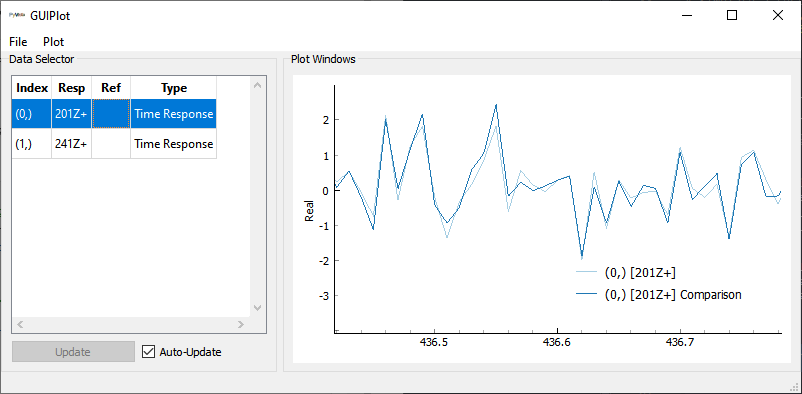

At this point, we will compute frequency response functions for different noise schemes for various estimators.  In this case, we will only consider H<sub>1</sub>, H<sub>2</sub>, and H<sub>v</sub>, though others could be considered as well.  In this case, we don't consider H<sub>cd</sub>, as it is nominally identical to H<sub>1</sub> as presented here.  H<sub>3</sub> would simply be the average of H<sub>1</sub> and H<sub>2</sub>.  We will compute frequency response functions for the no-noise case, as well as cases where noise is either on the reference or the response or both, so we set up dictionaries to hold this information.

In [ ]:
frf_no_noise = {}
frf_ref_noise = {}
frf_res_noise = {}
frf_both_noise = {}
# ['H1','H2','H3','Hcd','Hv'] Could look at any of these
frf_types = ['H1','H2','Hv'] 

We then go through a for loop over all frequency response function estimators and compute the frequency response function for each noise case using the `sdynpy.TransferFunctionArray.from_time_data` method.  We pass the reference and response signals, the technique used to compute the frequency response function, and the number of samples per measurement frame.  We then use the `extract_elements` method of the `TransferFunctionArray` objects to get the same frequency lines that are in the truth data.  We store 

In [ ]:
for frf_type in frf_types:
    frf_no_noise[frf_type] = sdpy.TransferFunctionArray.from_time_data(
        reference_signals,response_signals,method=frf_type,
        samples_per_average = 2000).extract_elements(slice(1,-1))
    frf_ref_noise[frf_type] = sdpy.TransferFunctionArray.from_time_data(
        reference_signals_noise,response_signals,method=frf_type,
        samples_per_average = 2000).extract_elements(slice(1,-1))
    frf_res_noise[frf_type] = sdpy.TransferFunctionArray.from_time_data(
        reference_signals,response_signals_noise,method=frf_type,
        samples_per_average = 2000).extract_elements(slice(1,-1))
    frf_both_noise[frf_type] = sdpy.TransferFunctionArray.from_time_data(
        reference_signals_noise,response_signals_noise,method=frf_type,
        samples_per_average = 2000).extract_elements(slice(1,-1))

Finally, we can plot the frequency response functions as well as the error.  

In [ ]:
# Loop through all FRF noise cases
for frf_data,title in zip([frf_no_noise,frf_ref_noise,
                                frf_res_noise,frf_both_noise],
                          ['No Noise','Noise on Reference',
                           'Noise on Response','Noise on Both']):
    # Create a figure with FRF and error subplots
    fig,axes = plt.subplots(2,1,sharex=True,num=title)
    # Loop through each frf estimator
    for frf_type in frf_types:
        frf = frf_data[frf_type]
        axes[0].plot(frf[0,0].abscissa,np.abs(frf[0,0].ordinate),linewidth=1)
        # Compute the error
        error = frf-frf_truth
        axes[1].plot(error[0,0].abscissa,np.abs(error[0,0].ordinate),linewidth=1)
    
    # Plot formatting
    axes[0].plot(frf_truth[0,0].abscissa,np.abs(frf_truth[0,0].ordinate),'k',linewidth=0.5)
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[0].set_title(title)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[-1].legend(frf_types)
    axes[0].set_ylabel('|FRF|')
    axes[1].set_ylabel('|Error|')

We see some interesting results. in the above plots.  Starting with the no-noise case, all estimators provide an equivalent estimate of the frequency response function.  This is intuitive, as they all are trying to compute the same quantity, and if there are no errors, they should all be able to precisely compute that quantity.

Looking at the case where there is noise on the reference forces, we see that as expected, the H<sub>2</sub> estimator does outperform the H<sub>1</sub> and H<sub>v</sub> estimators (these two estimators are almost exactly overlaid in the figure).  Alternatively, when the noise is on the responses, the H<sub>1</sub> and H<sub>v</sub> estimators significatly out-perform the H<sub>2</sub> estimator (again, the H<sub>1</sub> and H<sub>v</sub> estimators are almost exactly overlaid in the figure).  Finally, when there is noise on both input forces and responses, we see that the H<sub>1</sub> and H<sub>v</sub> estimators perform much better than the H<sub>2</sub> estimator in the valleys between the resonances, but the H<sub>2</sub> estimator marginally wins at resonances.

One interesting feature of this analysis is that the H<sub>1</sub> and H<sub>v</sub> estimators provide almost exactly the same estimate of the frequency response function.  Given that the H<sub>v</sub> estimator aims to handle noise on both references and responses, it was expected to perform better than the H<sub>1</sub> estimator in the case where noise was applied to both.

### SignalProcessingGUI

SDynPy also offers the capability to compute frequency response functions via graphical user interface rather than code.

## Summary

This tutorial presented the theory behind computing frequency response functions experimentally.  It showed three ways to perform the analysis.  The first approach is a narrow-band approach, where the shaker excites the structure at a single sine frequency, and responses to that excitation are measured.  The ratio between response and excitation amplitude, and the phase change between the two signals can be directly used to populate the frequency response function matrix.  While this can be used to very accurately compute the frequency response function, it is dreadfully slow because the test must be run hundreds or thousands of times to compute enough frequency lines for the frequency response function matrix.

Building off the first approach, the second approach substitutes the narrow-band sinusoidal signal for a broadband signal that excites many frequency lines.  The analogous ratioing of the magnitudes and subtraction of the phases to compute the frequency response function can be performed using the FFT of the signals.  While this approach works in theory, it is not used in practice due to the difficulty in averaging multiple signals together, as well as the inability to excite the structure with multiple shakers simultaneously.

By far the most popular techniques for computing frequency response functions are via computing power spectra from the response and reference time signals.  In this case, averaging can be intuitively added to the signal processing, and multiple simultaneous excitations can be handled gracefully.  Several frequency response function estimators were described and used to compute frequency response functions from a simulated test with noise added.  The H<sub>1</sub> and H<sub>v</sub> techniques appeared to perform the most favorably.

## Homework Problems

### 1. Simulate a Test to Generate Time Histories

Using the homework problem from the previous tutorial, write equation for the eigenvalue problem using the mass and stiffness matrices.

![3-mass System](../Modal_03_Multi_DoF_Vibrations/figures/spring_mass_3.svg)

$m_1=10$, $m_2 = 30$, $m_3 = 1$, $k_1 = 10000$, $k_2 = 2500$, $k_3 = 1500$, $k_4 = 1500$, $c_1 = 30$, and $c_2 = 50$.

Use XXX Excitation...

### 2. Compute Frequency Response Functions

Compute the frequency response functions between a force at mass 1 and 3 using the H<sub>1</sub> technique.  Compare them to the frequency response functions computed in previous tutorials.

